This Notebook was built to solve different r-deFBA models and investigate their variability, using r-deFVA.

It lets the user choose from a numerous scenarios (i.e., initial conditions) and gives several choices on how the MILP is created and solved.

**Note: To run r-deFVA, CPLEX must be used!**

# Imports

In [1]:
import copy 
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from time import sleep

# module_path = os.path.abspath(os.path.join('..'))
# if module_path not in sys.path:
#     sys.path.append(module_path)
from pyrrrateFBA.pyrrrateModel import Model

from src import RESULT_PATH, LPFILE_PATH, FIGURE_PATH, FVA_PATH, discretization_schemes
from src.optimization_problem.OptimizationProblem import rdeFBA_Problem
from src.helpers import compute_biomass, compute_state_changes, create_dataframes_from_solution
from src.notebook.helpers import set_initial_values, print_y_and_u, print_var_indices, plotting
from src.models import toy_model, self_replicator, covert2001, simulation_dicti


# 1 General User Input
In the following you can choose a model and scenario, and define different parameters, such as the discretization method or scaling factors. These always have to be defined. For simulations, as well as r-deFVA

### 1.1.1 Choose Model and Scenario
You can choose from four different models and their respective scenarios. Scenarios define the initial conditions (environment), the simulation time, and number of timesteps.:
* (Model) `toy_model` - Toy Model
    * (Scenario) `'toy_model'` - Default scenario to show optimal solution can be non-unique  <br/><br/>
* (Model) `self_replicator` - Regulatory Self Replicator
    * (Scenario) `'sr_default'` - Aerobic growth on two carbon sources
    * (Scenario) `'sr_high'` - Same as the default scenario, but with very large initial carbon amounts. Can break regulatory rules <br/><br/>
* (Model) `covert01` - Core Carbon Model
    * (Scenario) `'cov01_scenario1'` - Aerobic growth on two carbon sources
    * (Scenario) `'cov01_scenario2'` - Switch from aerobic to anaerobic growth
    * (Scenario) `'cov01_scenario3'` - Aerobic growth on carbon and amino acids, with carbon in excess.
    * (Scenario) `'cov01_scenario4'` - Aerobic growth on carbon and amino acids, with amino acids in excess. <br/><br/>
* (Model) `covert02` - E.coli Core Model
    * (Scenario) `'cov02_default'` - Aerobic growth on glucose
    
To define your own scenario, set `scenario=None` and define the initial conditions, simulation time and number of timesteps in Sec. 1.1.3


In [2]:
### Toy Model
# model = toy_model
# scenario = 'tm_default'

### Self-Replicator Model
model = self_replicator
scenario = 'sr_default'
# scenario = 'sr_high'

### Carbon Core Model (Covert01)
# model = covert2001
# scenario = 'cov01_scenario1'
# scenario = 'cov01_scenario2'
# scenario = 'cov01_scenario3'
# scenario = 'cov01_scenario4'

### E.coli Core Model
# model = covert02
# scenario = 'cov02_default'


# scenario = None

### 1.1.2 Additional Parameters:

r-deFBA parameters concern the model building. They define things like the temporal discretization method, model scaling, etc.:

* `rdeFBA`   -   a boolean. Determines whether r-deFBA (`True`) or deFBA (`False`) is carried out
* `phi` - float. discount parameter in objective function. Default is 0.001
* `discretization_method` - a string. Defines the method used for temporal discretization. Choices are: `default` (trapezoidal + midpoint rule), `explicit_euler`, `implicit_euler`, `implicit_midpoint`, `trapezoidal`, `rk4`.
* `indicator_constraints` - a boolean. If `True` regulatory constraints are created as indicator constraints. Otherwise bigM formulation is used.
* `eps_scaling_factor` - a tuple of size 2 defining the scaling factors. Elements of the tuple can be either floats or arrays of floats. First element defines the scaling of dynamical species, second element defines scaling of reaction fluxes. If a single float is given, all species/fluxes are scaled by the same factor. If an array is passed, the array must contain a value for **every** dynamical species/reaction flux. Set to `(1, 1)` for no scaling.

Optimization parameters include solver parameters, verbosity, etc.:

* `write_model` - a boolean. If `True` the MILP will be written to a .lp-file
* `mip_file` - a string or Path object. Path/to/lp-file to where the MILP will be written.
* `logfile` - a string or Path object. Path/to/logfile. The CPLEX optimization log will be written to the logfile
* `verbosity_level` - an integer [1-3]. 1-No feedback, 2-Prints optimal value, 3-Prints optimization log
* `solver_parameters` - dictionary. Set solver parameters (key) and their values (value) here.\
  A list of CPLEX parameters can be found here: [CPLEX](https://www.ibm.com/docs/en/icos/12.8.0.0?topic=cplex-list-parameters), [Gurobi](https://www.gurobi.com/documentation/current/refman/parameters.html), [SCIP](https://www.scipopt.org/doc/html/PARAMETERS.php). 

***Note: BigM and small epsilon can currently not be changed from within this notebook. These values can only be changed in the source code. To do so, open: path_to_repository/pyrrrateFBA/optimization/lp.py and change bigM and small epsilon in lines 21 and 22***

In [3]:
# r-deFBA PARAMETERS
rdeFBA = True
phi = 0.001
discretization_method = 'default'
indicator_constraints = True
scaling_factors = (1, 1)

# OPTIMIZATION PARAMETERS
write_model = False
mip_file = RESULT_PATH / LPFILE_PATH / f"{scenario}.lp"
verbosity_level = 3

solver_parameters = {
    # 'simplex.tolerances.feasibility': 1e-9,     # CPLEX - Feasibility Tolerance
    # 'mip.tolerances.integrality': 0,            # CPLEX - Integrality Tolerance
    # 'emphasis.numerical': 1,                    # CPLEX - Numerical Emphasis (0-off, 1-on)
    # 'mip.strategy.startalgorithm': 4,           # CPLEX - Root Solving Algorithm
    # 'timelimit': 2400                           # CPLEX - Time limit in seconds
    
    # 'FeasibilityTol': 1e-9,                     # Gurobi - Feasibility Tolerance
    # 'IntFeasTol': 0,                            # Gurobi - Integrality Tolerance
    # 'NumericFocus': 2                           # Gurobi - Numerical Focus (0-3)
    
    # 'numerics/feastol': 1e-6                    # SCIP - Feasibility Tolerance
}

### 1.1.3 Define your own simulation
To define your own scenario, first set `scenario = None` in section 1.1.1.  Then set the initial values (`environment` and `macromolecules`), simulation time `t_end` and number of discretization steps `n`

 * Initial amounts of extracellular species can be defined in the dictionary `environment` (key-species name, value-initial amount [mmol]) (e.g. `'Carbon1': 1000`). Any species that is not defined starts with 0.0mmol. 
 * Initial values of macromolecules can be defined in the dictionary `macromolecules` (key - macromolecule name, value - amount in mmol).\
   For those macromolecules where no initial value is set, the initial amount will be chosen by the solver, such that the initial biomass is 1g.
   
These inputs will be ignored if a preset scenario was chosen in Sec. 1.1.1

To see what species (extracellular and macromolecules) the model contains, execute the cell below.

In [4]:
# Print Model Species
print_y_and_u(model, 'y')

Extracellular Species:
['C1', 'C2']

Enzymes and Structural Compounds (Macromolecules):
['T1', 'T2', 'R', 'Q']

Regulatory proteins (Macromolecules):
['RP']


In [5]:
# INITIAL VALUES & MODEL PARAMETERS

extracellular = {
    # 'C1': 1000,
}

macromolecules = {
}

t_end = 50
n = 50


# 2. Solve r-deFBA problem

Execute the cell below to simulate the previously specified model. Simulation results will be stored in dataframes `df_y` (dynamic species), `df_u` (reaction fluxes) and `df_x` (regulatory variables). 

Simulation results can be plotted in Section 3.

In [6]:
# set initial values
if scenario is not None:
    y0 = simulation_dicti[scenario]['y0']
    tspan = (0, simulation_dicti[scenario]['t_sim'])
    n_steps = simulation_dicti[scenario]['n_steps']
else:
    y0 = np.zeros((1, len(model.extracellular_dict) + len(model.macromolecules_dict)))
    y0[0, len(model.extracellular_dict):] = np.nan
    tspan = (0, t_end)
    n_steps = n
    set_initial_values(model, y0, extracellular, macromolecules)


rdeFBA_kwargs = {
    'n_steps': n_steps,
    'run_rdeFBA': rdeFBA,
    'indicator_constraints': indicator_constraints,
    'set_y0': y0,
    'scaling_factors': scaling_factors,
    'runge_kutta': discretization_schemes[discretization_method]
}

optimization_kwargs = {
    'parameters': solver_parameters,
    'verbosity_level': verbosity_level,
    'write_model': write_model,
}

# solve MILP
solution = model.rdeFBA(tspan=tspan, varphi=phi, optimization_kwargs=optimization_kwargs, **rdeFBA_kwargs)

# store solution in dataframes and compute biomass
df_y, df_u, df_x = create_dataframes_from_solution(model=model, solution=solution, run_rdeFBA=rdeFBA)
biomass = compute_biomass(model=model, df=df_y)

Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
Tried aggregator 2 times.
MIP Presolve eliminated 8 rows and 34 columns.
MIP Presolve modified 327 coefficients.
Aggregator did 213 substitutions.
Reduced MIP has 1280 rows, 1120 columns, and 4452 nonzeros.
Reduced MIP has 119 binaries, 0 generals, 0 SOSs, and 125 indicators.
Presolve time = 0.01 sec. (4.11 ticks)
Probing fixed 1 vars, tightened 1103 bounds.
Probing time = 0.02 sec. (10.53 ticks)
Tried aggregator 2 times.
Detecting symmetries...
MIP Presolve eliminated 4 rows and 4 columns.
MIP Presolve modified 181 coefficients.
Aggregator did 51 substitutions.
Reduced MIP has 1225 rows, 1065 columns, and 4385 nonzeros.
Reduced MIP has 118 binaries, 0 generals, 0 SOSs, and 125 indicators.
Presolve time = 0.01 sec. (3.43 ticks)
Probing fixed 2 vars, tightened 842 bounds.
Probing time = 0.01 sec. (6.32 ticks)
Clique table members: 95.
MIP emphasis: balance optimality and feasibility.

# 3 Plotting

In the following section you can plot the simulation results from section 2. These include substrate-, enzyme- and regulatory protein amounts, as well as biomass, reaction fluxes and regulatory states over time.

You can define which substrates, enzymes, regulatory proteins and reaction fluxes to plot, by listing them in `substrates_to_plot`, `enzymes_to_plot`, `rp_to_plot` and `reactions_to_plot`, respectively.
By leaving the lists empty, all variables of the respective group will be plotted.

An overview of all substrates, macromolecules and reactions can be displayed by executing cell 3.2.

## 3.1 User Input for Plotting

* `show_state_changes` - a boolean. If true state changes are shown in all figures as vertical lines.
* `substrates_to_plot` - a list containing all the substrates to plot.
* `enzymes_to_plot` - a list containing all the enzymes to plot.
* `rp_to_plot` - a list containing all the regulatory proteins to plot.
* `quota_to_plot` - a list containing all the quota species to plot.
* `reactions_to_plot` - a list containing all the reactions to plot.



In [7]:
show_state_changes = True

extracellular_to_plot = []
enzymes_to_plot = []
rp_to_plot = []
quota_to_plot = []
reactions_to_plot = []

## 3.2 Display Model Overview

In [8]:
print_y_and_u(model)

Extracellular Species:
['C1', 'C2']

Enzymes and Structural Compounds (Macromolecules):
['T1', 'T2', 'R', 'Q']

Regulatory proteins (Macromolecules):
['RP']

Exchange reactions:
[]

Metabolic reactions:
[]

Macromolecule synthesis reactions:
['vC1', 'vC2', 'vQ', 'vR', 'vT1', 'vT2', 'vRP']


## 3.3 Plotting
Execute the cell below to plot

Text(0.5, 0, 'Time')

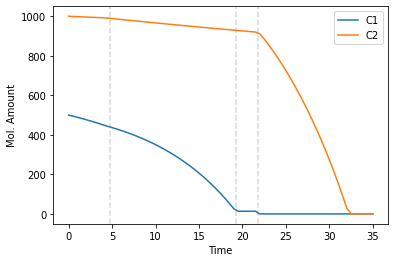

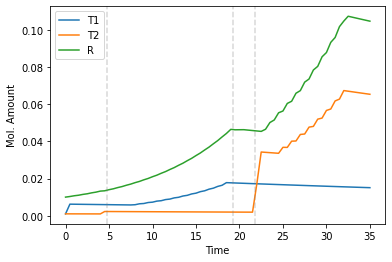

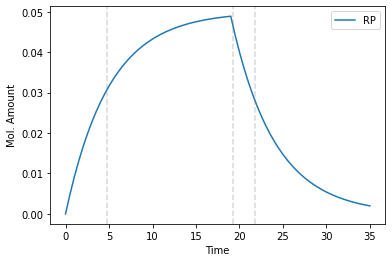

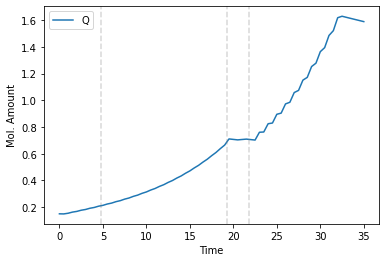

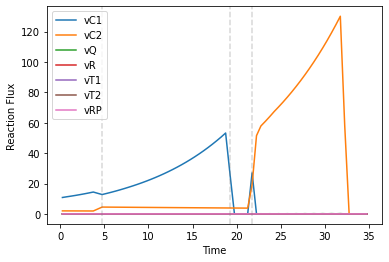

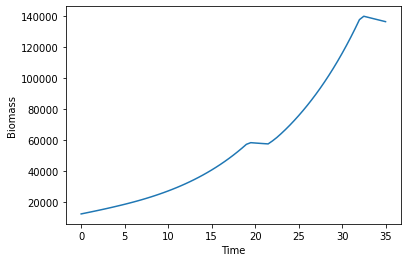

In [9]:
plt.rcParams['figure.dpi'] = 50   # quality of plots shown in notebook

# compute time of state changes
df_state_changes = compute_state_changes(df_x)
if show_state_changes:
    state_changes = df_state_changes.index[1:]
else:
    state_changes = []

# plot extracellular species
fig_ext, ax_ext = plt.subplots()
plotting(model, df_y, extracellular_to_plot, 'extracellular', ax_ext, state_changes)

# plot enzymes
fig_enz, ax_enz = plt.subplots()
plotting(model, df_y, enzymes_to_plot, 'enzymes', ax_enz, state_changes)

# # plot regulatory proteins
fig_rp, ax_rp = plt.subplots()
plotting(model, df_y, rp_to_plot, 'rp', ax_rp, state_changes)

# # plot structural compounds (Quota)
fig_q, ax_q = plt.subplots()
plotting(model, df_y, quota_to_plot, 'quota', ax_q, state_changes)

# # plot reactions
fig_react, ax_react = plt.subplots()
plotting(model, df_u, reactions_to_plot, 'reactions', ax_react, state_changes, ylabel='Reaction Flux')

# # plot biomass
biomass = compute_biomass(model, df_y)
fig_biomass, ax_biomass = plt.subplots()
ax_biomass.plot(df_y.index, biomass)
ax_biomass.set_ylabel('Biomass')
ax_biomass.set_xlabel('Time')
# plotting(df_y, biomass_to_plot, ax_biomass)
# print state change table


# 4 r-deFVA
In the following section we can run an r-deFVA on the previously specified model. r-deFVA creates two files called `<var>_min.tsv` and `<var>_min.tsv` containing the min and max trajectories of each variable. `<var>` is the variable type used. The files will be stored under `rdeFBA-Variability/results/rdeFVA/`.

Before running r-deFVA some additional user inputs are required.

**Note: The current implementation of r-deFVA only works with CPLEX!**

## 4.1 User Input
`var_type` - The variable type on which you want to investigate for variability. Possible choices are 'y' (dynamic species) and 'u' (reactions)
`var_indices` - The indices of the variables to investigate variability. Choose `None` for all variables of the respective variables type. To display variables and their indices run the command `print_var_indices(model)` in the cell below
`relaxation_constants` - A tuple defining the relative and absolute relaxation constant 

In [10]:
var_type = 'y'                         # possible choices are 'y', 'u'
var_indices = None
relaxation_constants = (1e-6, 1e-6)

In [11]:
print_var_indices(model)

# Dynamic Species (y)
{0: 'C1', 1: 'C2', 2: 'T1', 3: 'T2', 4: 'R', 5: 'RP', 6: 'Q'}

# Reactions (u)
{0: 'vC1', 1: 'vC2', 2: 'vQ', 3: 'vR', 4: 'vT1', 5: 'vT2', 6: 'vRP', 7: 'kdQ', 8: 'kdR', 9: 'kdT1', 10: 'kdT2', 11: 'kdRP'}


In [12]:
# set initial values
if scenario is not None:
    y0 = simulation_dicti[scenario]['y0']
    tspan = (0, simulation_dicti[scenario]['t_sim'])
    n_steps = simulation_dicti[scenario]['n_steps']
else:
    y0 = np.zeros((1, len(model.extracellular_dict) + len(model.macromolecules_dict)))
    y0[0, len(model.extracellular_dict):] = np.nan
    tspan = (0, t_end)
    n_steps = n
    set_initial_values(model, y0, extracellular, macromolecules)


rdeFBA_kwargs = {
    'n_steps': n_steps,
    'run_rdeFBA': rdeFBA,
    'indicator_constraints': indicator_constraints,
    'set_y0': y0,
    'scaling_factors': scaling_factors,
    'runge_kutta': discretization_schemes[discretization_method]
}

optimization_kwargs = {
    'parameters': solver_parameters,
    'verbosity_level': verbosity_level,
    # 'write_model': write_model,
}
    
optimization_problem = rdeFBA_Problem(model, **rdeFBA_kwargs)
optimization_problem.create_MIP()
df_min, df_max, _ = optimization_problem.run_rdeFVA(var_indices=var_indices, var_type=var_type, relaxation_constants=relaxation_constants, fva_level=1, return_solution=False, optimization_kwargs=optimization_kwargs)

df_min.to_csv(FVA_PATH / f'{var_type}_min.tsv', sep='\t')
df_max.to_csv(FVA_PATH / f'{var_type}_max.tsv', sep='\t')

print(f"\nResults saved to:\n   {FVA_PATH / var_type}_min.tsv and\n   {FVA_PATH / var_type}_max.tsv")

####################
Perform r-deFBA
####################
####################
Perform r-deFVA
####################
In deFVA, min-/maximizing C1 (y_1)
In deFVA, min-/maximizing C2 (y_2)
In deFVA, min-/maximizing T1 (y_3)
In deFVA, min-/maximizing T2 (y_4)
In deFVA, min-/maximizing R (y_5)
In deFVA, min-/maximizing RP (y_6)
In deFVA, min-/maximizing Q (y_7)

Results saved to:
   /home/yannid/repos/rdeFBA-Variability/results/rdeFVA/y_min.tsv and
   /home/yannid/repos/rdeFBA-Variability/results/rdeFVA/y_max.tsv
